# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

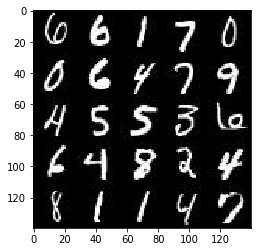

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

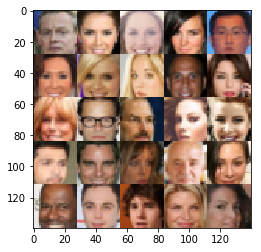

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28x28x3
        l1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        l1 = tf.maximum(alpha*l1, l1) # Leaky ReLU
        
        
        l2 = tf.layers.conv2d(l1, 128, 5, strides=2, padding='SAME')
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = tf.maximum(alpha*l2, l2)
        
        
        l3 = tf.layers.conv2d(l2, 256, 5, strides=2, padding='SAME')
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = tf.maximum(alpha*l3, l3)
        # 4x4x256
        
        flat = tf.reshape(l3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        l1 = tf.layers.dense(z, 7*7*256)
        l1 = tf.reshape(l1, (-1, 7, 7, 256))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha * l1, l1)
        
        l2 = tf.layers.conv2d_transpose(l1, 128, 5, strides=2, padding='SAME')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha * l2, l2)
        
        l3 = tf.layers.conv2d_transpose(l2, 64, 5, strides=2, padding='SAME')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(alpha * l3, l3)
        
        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, strides=1, padding='SAME')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # Initializing Variables with predictions
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate the Losses for it real, fake & generated models
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # The Discriminator Loss is the amount of it fake img loss + it real img loss
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # emtpy trainiable variables
    t_vars = tf.trainable_variables()
    
    #discriminator optimization
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_w, img_h, img_d = data_shape
    input_real, input_z, lr = model_inputs(img_w, img_h, img_d, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, img_d)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    losses = []
    saver = tf.train.Saver()

    samples = []
    steps = 0
    print_every = 30
    show_every = 100
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2 
                steps += 1

                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})

                if steps % print_every == 0:
                    # Print losses after each epcoh
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses for later investigations
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, img_d, data_image_mode)

        saver.save(sess, './generator.ckpt')
    
    return losses
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0773... Generator Loss: 5.0923
Epoch 1/2... Discriminator Loss: 0.3286... Generator Loss: 2.5931
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 3.4215


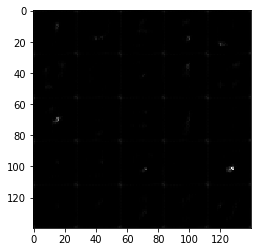

Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.4854
Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 0.6381
Epoch 1/2... Discriminator Loss: 1.3515... Generator Loss: 0.6689


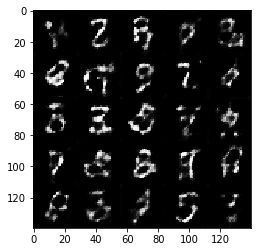

Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.8817
Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 0.4714
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 0.7913
Epoch 1/2... Discriminator Loss: 1.5396... Generator Loss: 1.8806


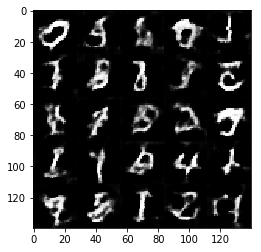

Epoch 1/2... Discriminator Loss: 1.0943... Generator Loss: 0.8343
Epoch 1/2... Discriminator Loss: 1.5151... Generator Loss: 0.3652
Epoch 1/2... Discriminator Loss: 1.1479... Generator Loss: 0.6922


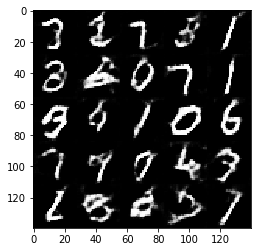

Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 0.8436
Epoch 1/2... Discriminator Loss: 1.0488... Generator Loss: 0.9236
Epoch 1/2... Discriminator Loss: 1.1722... Generator Loss: 0.6480


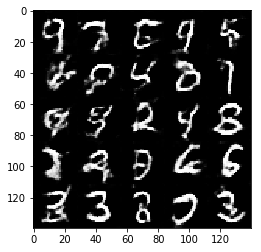

Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 1.1759
Epoch 1/2... Discriminator Loss: 1.0966... Generator Loss: 0.9698
Epoch 1/2... Discriminator Loss: 1.4206... Generator Loss: 0.4105
Epoch 1/2... Discriminator Loss: 0.9967... Generator Loss: 0.8203


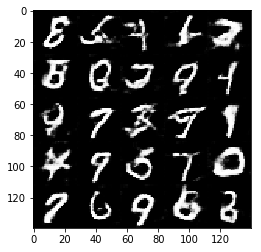

Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 1.0815... Generator Loss: 0.8559
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 0.7228


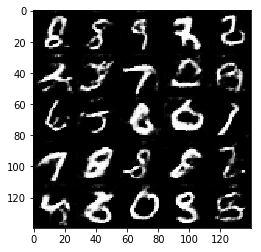

Epoch 1/2... Discriminator Loss: 0.9872... Generator Loss: 1.0793
Epoch 1/2... Discriminator Loss: 0.9819... Generator Loss: 0.8727
Epoch 1/2... Discriminator Loss: 1.0450... Generator Loss: 1.0308


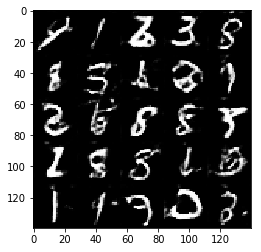

Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 0.4997
Epoch 1/2... Discriminator Loss: 1.1691... Generator Loss: 0.6838
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 0.6249
Epoch 1/2... Discriminator Loss: 1.0231... Generator Loss: 1.7786


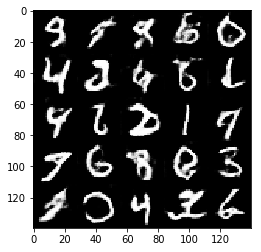

Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 0.4383
Epoch 2/2... Discriminator Loss: 1.0007... Generator Loss: 0.9150
Epoch 2/2... Discriminator Loss: 1.1551... Generator Loss: 0.6196


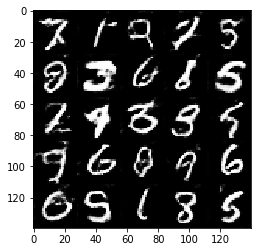

Epoch 2/2... Discriminator Loss: 2.0060... Generator Loss: 0.1968
Epoch 2/2... Discriminator Loss: 1.6242... Generator Loss: 2.0476
Epoch 2/2... Discriminator Loss: 1.1809... Generator Loss: 0.5413


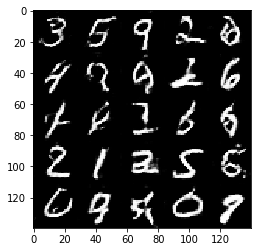

Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 0.7272
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 0.5801
Epoch 2/2... Discriminator Loss: 0.8939... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 1.3351... Generator Loss: 0.4486


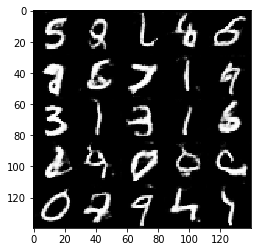

Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 1.4534
Epoch 2/2... Discriminator Loss: 1.2263... Generator Loss: 0.5779
Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 1.0965


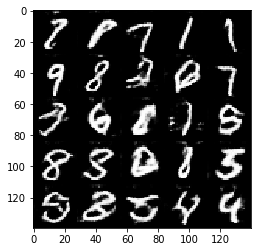

Epoch 2/2... Discriminator Loss: 1.1946... Generator Loss: 0.5402
Epoch 2/2... Discriminator Loss: 1.2266... Generator Loss: 0.4943
Epoch 2/2... Discriminator Loss: 1.0422... Generator Loss: 0.6907


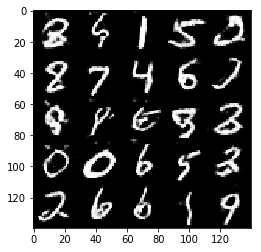

Epoch 2/2... Discriminator Loss: 1.0437... Generator Loss: 2.0291
Epoch 2/2... Discriminator Loss: 0.8768... Generator Loss: 0.8323
Epoch 2/2... Discriminator Loss: 0.9084... Generator Loss: 1.0665
Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 0.6555


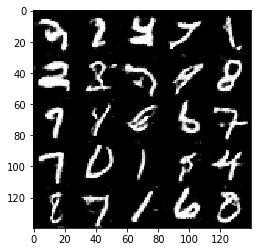

Epoch 2/2... Discriminator Loss: 1.0931... Generator Loss: 0.7659
Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 0.5205
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 0.6262


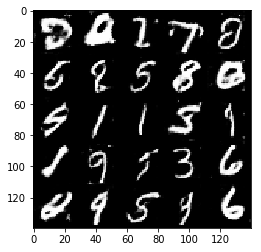

Epoch 2/2... Discriminator Loss: 1.3000... Generator Loss: 0.5022
Epoch 2/2... Discriminator Loss: 0.6189... Generator Loss: 1.7880
Epoch 2/2... Discriminator Loss: 1.2721... Generator Loss: 2.6873


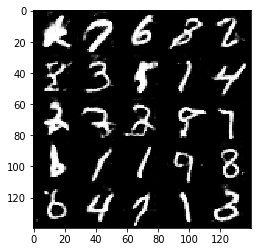

Epoch 2/2... Discriminator Loss: 1.1500... Generator Loss: 0.9179
Epoch 2/2... Discriminator Loss: 1.0135... Generator Loss: 1.0127
Epoch 2/2... Discriminator Loss: 1.5360... Generator Loss: 0.4583
Epoch 2/2... Discriminator Loss: 0.7525... Generator Loss: 1.4914


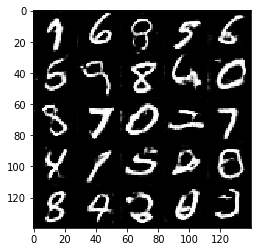

Epoch 2/2... Discriminator Loss: 1.7270... Generator Loss: 3.7501
Epoch 2/2... Discriminator Loss: 0.7599... Generator Loss: 1.9053


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.5091... Generator Loss: 0.0275
Epoch 1/1... Discriminator Loss: 0.5311... Generator Loss: 1.2115
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 3.9108


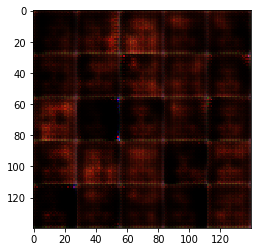

Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 1.7606
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 1.4422
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.6873


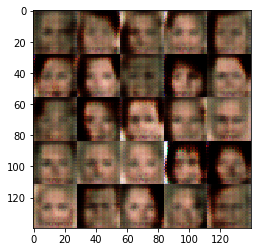

Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.4303
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.2666... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.6770


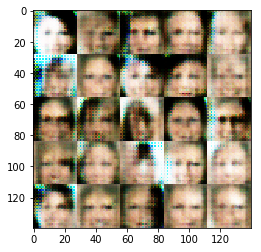

Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 2.1260... Generator Loss: 0.1489
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 1.0106


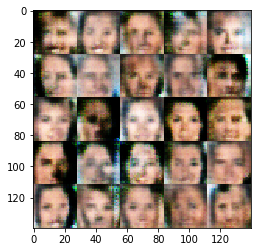

Epoch 1/1... Discriminator Loss: 1.6467... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.7186... Generator Loss: 1.9355


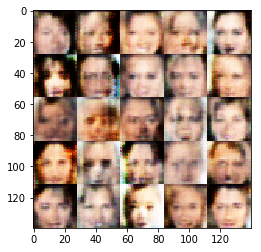

Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.4570
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.1848
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 1.2748
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.7795


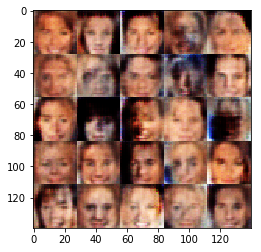

Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.6278


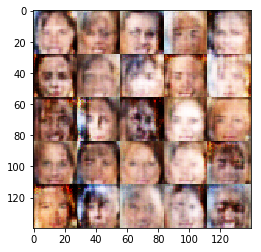

Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.6861... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.4704


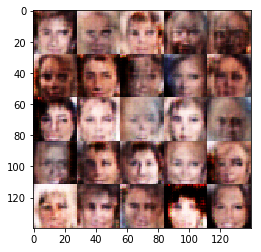

Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.8558


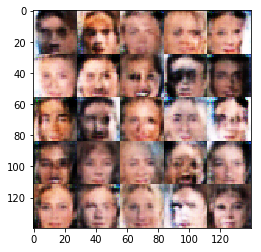

Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.5274


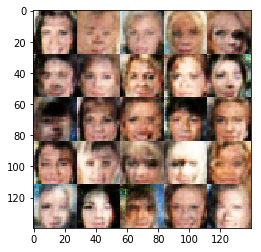

Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.4681
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.7818


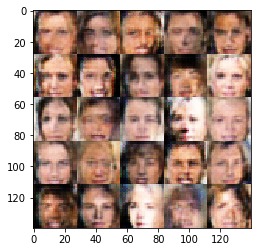

Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.6813
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.8205


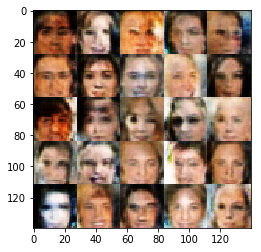

Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 0.6009


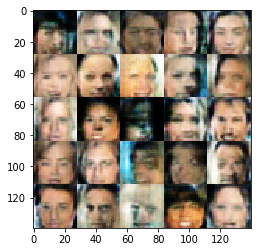

Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.4535


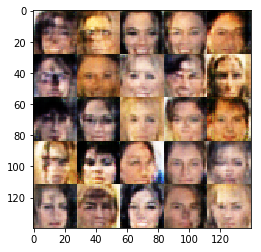

Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.5704
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.9260


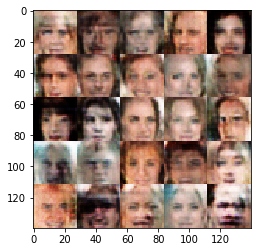

Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.6782


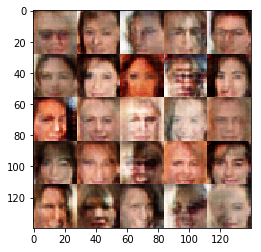

Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 1.2242


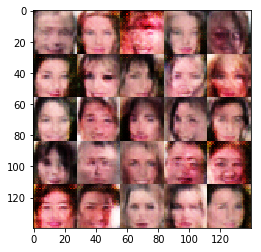

Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.6735


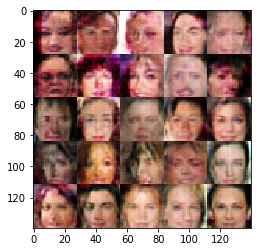

Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 1.3027
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 1.1422


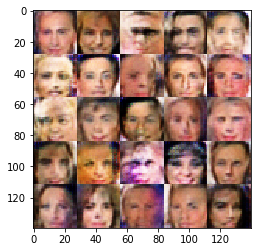

Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.6685


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.